In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Sekarang Anda dapat mengakses file di /content/drive/MyDrive/


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import os.path
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

Syntax diatas merupakan langkah awal dalam membuat program Python yang menggunakan beberapa pustaka atau modul terkenal untuk analisis data, pembuatan dan evaluasi model machine learning, serta visualisasi data.

In [ ]:
train_img_dir = Path('/content/drive/MyDrive/archive/PandasBears/Train')
test_img_dir = Path('/content/drive/MyDrive/archive/PandasBears/Test')

Pemanggilan data set pada google drive yang Syntax tersebut mendefinisikan dua variabel yang menyimpan path dari direktori training dan testing. Dengan menggunakan Path dari modul pathlib.

In [ ]:
filepath = list(train_img_dir.glob(r'**/*.jpeg'))
Label = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], filepath))
filepath = pd.Series(filepath, name = "Filepath").astype(str)
Label = pd.Series(Label, name = 'Label')
train_df = pd.concat([filepath, Label], axis = 1).sample(frac = 1.0, random_state = 1).reset_index(drop = True)

Membuat DataFrame dari file gambar di direktori tertentu.

In [ ]:
filepath = list(test_img_dir.glob(r'**/*.jpeg'))
Label = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], filepath))
filepath = pd.Series(filepath, name = "Filepath").astype(str)
Label = pd.Series(Label, name = 'Label')
test_df = pd.concat([filepath, Label], axis = 1).sample(frac = 1.0, random_state = 1).reset_index(drop = True)

Syntax diatas membuat DataFrame untuk set pengujian menggunakan pendekatan yang sama.

In [ ]:
train_df.shape

(500, 2)

In [ ]:
test_df.shape

(100, 2)

In [ ]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                           rotation_range = 30,
                                                           zoom_range = 0.2,
                                                           width_shift_range=0.1,
                                                           height_shift_range = 0.1,
                                                           horizontal_flip = True,
                                                           vertical_flip = False,
                                                           validation_split = 0.2)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)



Membuat generator data gambar dalam pelatihan dan pengujian model

In [ ]:
train_img = train_gen.flow_from_dataframe(dataframe = train_df,
                                         x_col = 'Filepath',
                                         y_col = 'Label',
                                         target_size = (224,224),
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         batch_size = 32,
                                         shuffle = True,
                                         seed = 42,
                                         subset = 'training')
val_img = train_gen.flow_from_dataframe(dataframe = train_df,
                                         x_col = 'Filepath',
                                         y_col = 'Label',
                                         target_size = (224,224),
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         batch_size = 32,
                                         shuffle = True,
                                         seed = 42,
                                         subset = 'validation')
test_img = test_gen.flow_from_dataframe(dataframe = test_df,
                                         x_col = 'Filepath',
                                         y_col = 'Label',
                                         target_size = (224,224),
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         batch_size = 32,
                                         shuffle = False)

Found 400 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


In [ ]:
class_names = train_img.class_indices.keys()
print(class_names)

dict_keys(['Bears', 'Pandas'])


In [ ]:
inputs = tf.keras.Input(shape = (224,224,3))
x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3),activation = 'relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAvgPool2D()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])
history = model.fit(train_img, validation_data = val_img,
                   epochs = 100,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                               patience = 5,
                                                               restore_best_weights = True))

Epoch 1/100
13/13 [==============================] - 28s 2s/step - loss: 0.6846 - accuracy: 0.5025 - val_loss: 0.6650 - val_accuracy: 0.9800
Epoch 2/100
13/13 [==============================] - 21s 2s/step - loss: 0.6327 - accuracy: 0.9525 - val_loss: 0.5576 - val_accuracy: 1.0000
Epoch 3/100
13/13 [==============================] - 31s 2s/step - loss: 0.4780 - accuracy: 0.9600 - val_loss: 0.3074 - val_accuracy: 0.9800
Epoch 4/100
13/13 [==============================] - 25s 2s/step - loss: 0.2501 - accuracy: 0.9725 - val_loss: 0.0972 - val_accuracy: 1.0000
Epoch 5/100
13/13 [==============================] - 22s 2s/step - loss: 0.1434 - accuracy: 0.9650 - val_loss: 0.0987 - val_accuracy: 0.9600
Epoch 6/100
13/13 [==============================] - 21s 2s/step - loss: 0.1177 - accuracy: 0.9700 - val_loss: 0.0370 - val_accuracy: 1.0000
Epoch 7/100
13/13 [==============================] - 21s 2s/step - loss: 0.0838 - accuracy: 0.9700 - val_loss: 0.0464 - val_accuracy: 0.9900
Epoch 8/100
1

In [ ]:
results = model.evaluate(test_img, verbose = 0)
print(f'Test Loss : {round(results[0], 3)}')
print(f'Test Accuracy : {round(results[1], 4)*100}%')

Test Loss : 0.04
Test Accuracy : 99.0%


<ipython-input-53-a48f74f2c61b>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss_values, 'b',  color='blue', label='Training loss')
<ipython-input-53-a48f74f2c61b>:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss_values, 'b', color='red', label='Validation loss' )


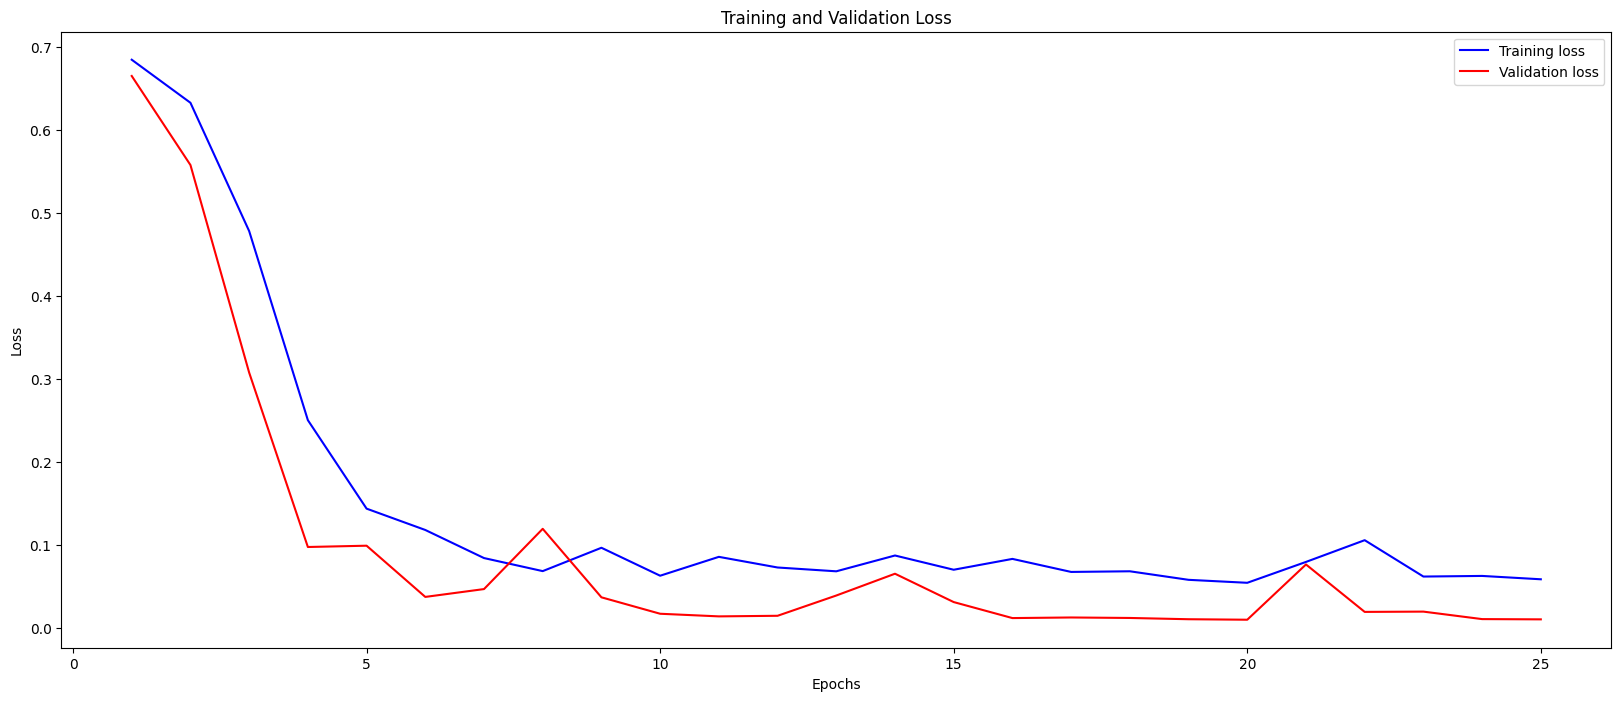

<ipython-input-53-a48f74f2c61b>:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc_values, 'b', color='blue', label='Training accuracy')
<ipython-input-53-a48f74f2c61b>:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc_values, 'b', color='red',label='Validation accuracy' )


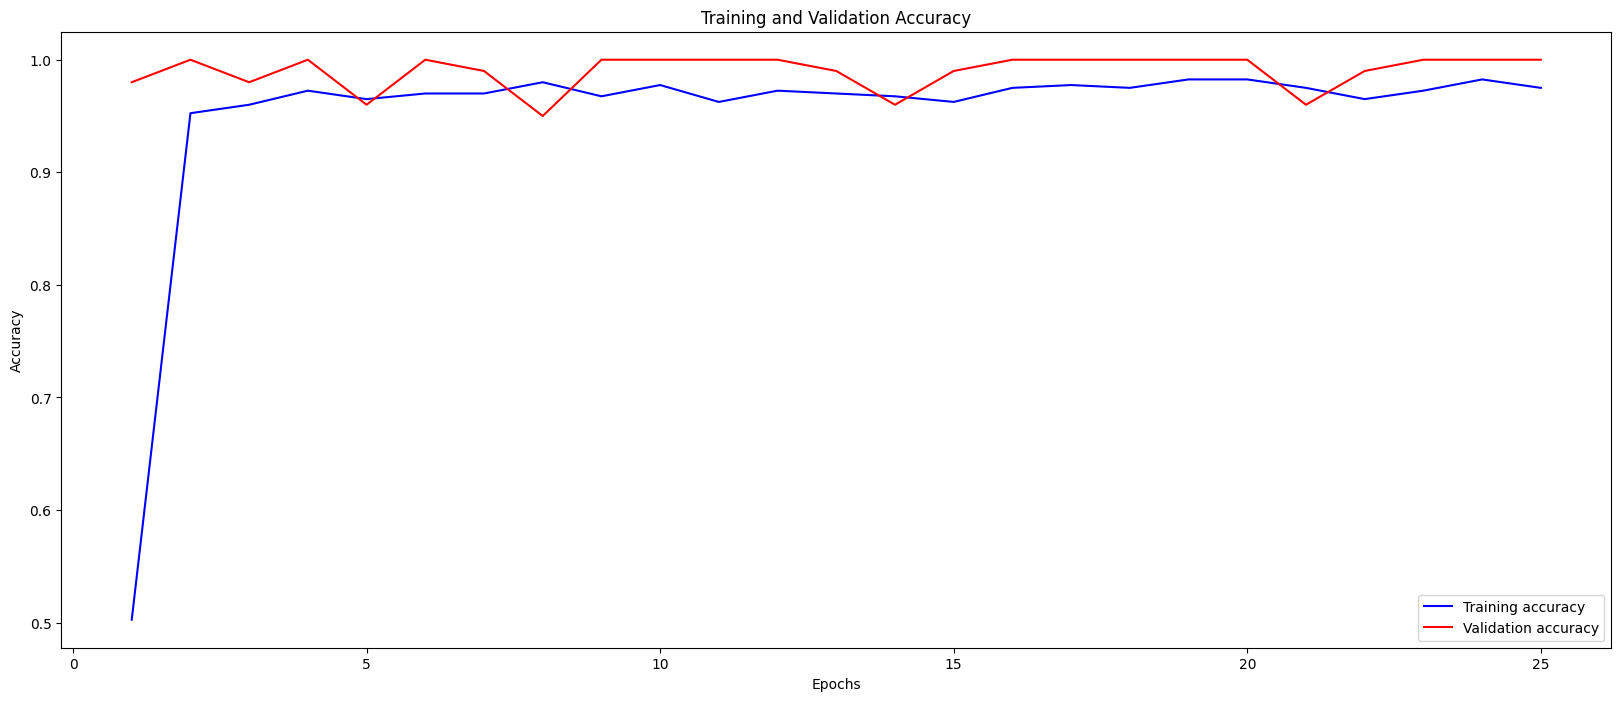

In [ ]:
import matplotlib.pyplot as plt

# Melihat metrik pelatihan dan validasi dari objek history
history_dict = history.history

# Plot loss pada set pelatihan dan set validasi
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'b',  color='blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', color='red', label='Validation loss' )
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot akurasi pada set pelatihan dan set validasi
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'b', color='blue', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', color='red',label='Validation accuracy' )
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch = train_generator.samples// batch_size,
                    validation_data= val_generator,
                    validation_steps = val_generator.samples// batch_size,
                    epochs = 8)

Epoch 1/8
12/12 [==============================] - 72s 6s/step - loss: 1.1647 - accuracy: 0.7092 - val_loss: 0.0531 - val_accuracy: 1.0000
Epoch 2/8
12/12 [==============================] - 65s 5s/step - loss: 0.0333 - accuracy: 0.9891 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 3/8
12/12 [==============================] - 65s 5s/step - loss: 0.0056 - accuracy: 0.9974 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 4/8
12/12 [==============================] - 63s 5s/step - loss: 5.4450e-04 - accuracy: 1.0000 - val_loss: 8.6545e-05 - val_accuracy: 1.0000
Epoch 5/8
12/12 [==============================] - 71s 6s/step - loss: 8.3091e-05 - accuracy: 1.0000 - val_loss: 5.3327e-04 - val_accuracy: 1.0000
Epoch 6/8
12/12 [==============================] - 65s 5s/step - loss: 9.6941e-05 - accuracy: 1.0000 - val_loss: 3.1963e-04 - val_accuracy: 1.0000
Epoch 7/8
12/12 [==============================] - 67s 6s/step - loss: 4.1377e-05 - accuracy: 1.0000 - val_loss: 1.0627e-04 - val_accuracy: 1.

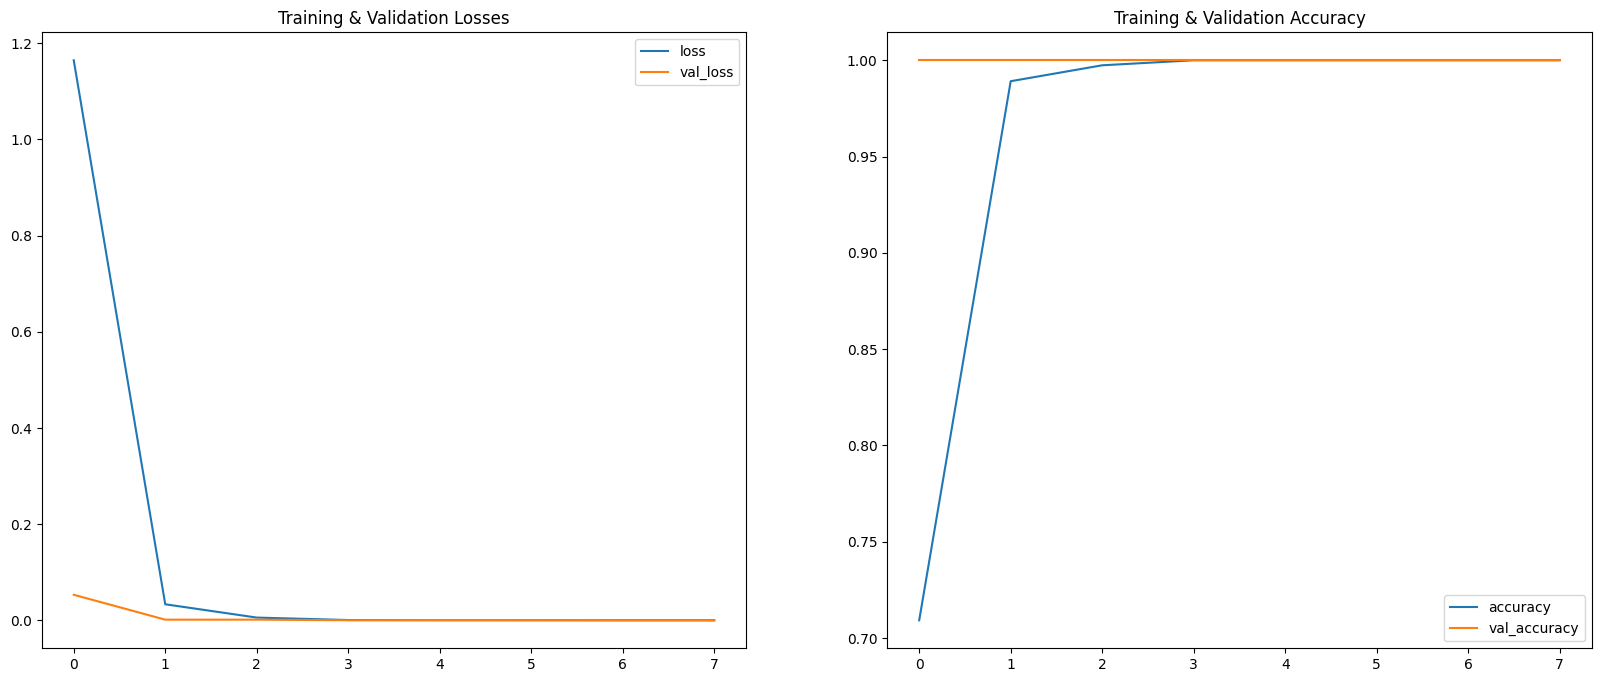

In [ ]:
train_func = ['loss', 'accuracy']
valid_func = ['val_loss', 'val_accuracy']
titles = [
    'Training & Validation Losses',
    'Training & Validation Accuracy'
]

def plotting_training_result(histories, title, i=1):
    plt.subplot(1, 2, i)
    for hist in histories:
        plt.plot(range(history_df.shape[0]), history_df[hist], label=hist)
    plt.title(title, fontsize=12)
    plt.legend()

for i in range(len(train_func)):
    plotting_training_result([train_func[i], valid_func[i]], title=titles[i], i=i+1)

4/4 [==============================] - 4s 696ms/step


<ipython-input-54-edbdc63d5a3e>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_img_pred = (model.predict(test_img) >= 0.5).astype(np.int)


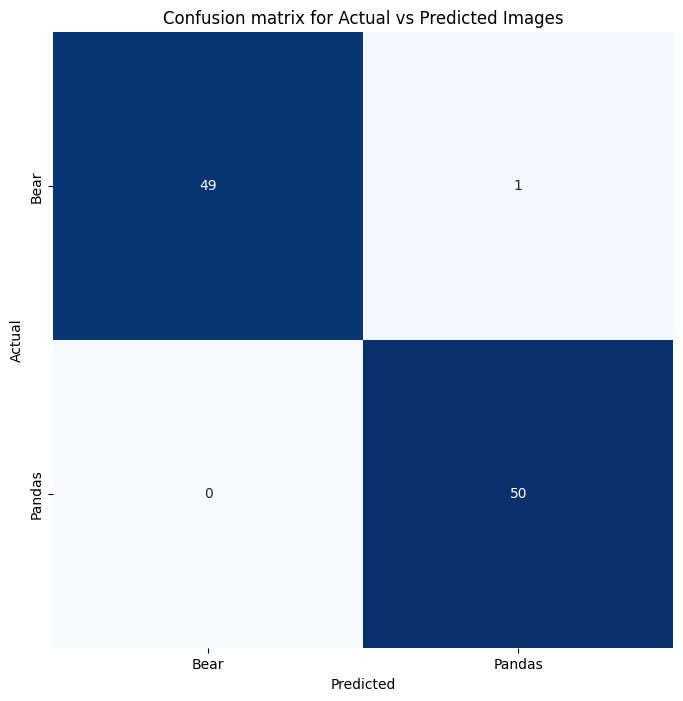

Classification Report---------->
               precision    recall  f1-score   support

        Bear       1.00      0.98      0.99        50
      Pandas       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [ ]:
test_img_pred = (model.predict(test_img) >= 0.5).astype(np.int)
cm = confusion_matrix(test_img.labels, test_img_pred, labels =[0,1])
clr = classification_report(test_img.labels, test_img_pred, labels = [0,1], target_names= ['Bear','Pandas'])
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, fmt = 'g', cbar = False, cmap = 'Blues')
plt.title('Confusion matrix for Actual vs Predicted Images')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks = [0.5, 1.5], labels= ['Bear','Pandas'])
plt.yticks(ticks= [0.5, 1.5], labels= ['Bear','Pandas'])
plt.show()
print('Classification Report---------->\n',clr)

In [ ]:
model.evaluate(test_generator)

4/4 [==============================] - 1s 277ms/step - loss: 0.0412 - accuracy: 0.9900


[0.04116029292345047, 0.9900000095367432]

In [ ]:
#Prediction image
from tensorflow.keras.preprocessing import image
import numpy as np
input_shape = (224, 224, 3)
img_path = '/content/drive/MyDrive/archive/ff.jpeg'
img = image.load_img(img_path, target_size=(input_shape))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalisasi

# Lakukan prediksi
predictions = model.predict(img_array)

1/1 [==============================] - 0s 134ms/step


In [ ]:
class_labels = sorted(os.listdir(test_path))

class_index = np.argmax(predictions)
class_name = class_labels[class_index]

# Print the predicted class
print("Predicted class:", class_name)

Predicted class: Bears
